<a href="https://colab.research.google.com/github/korakot/pythainlp_workshop/blob/master/notebooks/children_day_motto_dek.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

เห็น [งานวิเคราะห์อันนี้](https://facebook.com/736738277/posts/10158040605708278) เลยอยากทำบ้าง

เอา data จาก [ข่าวสด](https://www.khaosod.co.th/special-stories/news_2076271)

## Import, install

In [0]:
import pandas as pd
from collections import Counter

In [0]:
%load_ext google.colab.data_table

In [0]:
!pip install --pre pythainlp

In [0]:
import pythainlp
from pythainlp import word_tokenize, Tokenizer

In [0]:
from requests import get
from bs4 import BeautifulSoup

## Load data

In [0]:
url = 'https://www.khaosod.co.th/special-stories/news_2076271'
r = get(url)
soup = BeautifulSoup(r.text)
content = soup.find('div', 'td-post-content')
len(content.select('h3'))  # นายก 19 คน

19

In [0]:
h3 = content.h3
h3

<h3><strong>จอมพล ป. พิบูลสงคราม</strong></h3>

In [0]:
h3.find_next('ul')

<ul>
<li>พ.ศ. 2499 : จงบำเพ็ญตนให้เป็นประโยชน์ส่วนรวมแก่ผู้อื่น</li>
</ul>

In [0]:
li = h3.find_next('ul').li
li.text.split(maxsplit=3)

['พ.ศ.', '2499', ':', 'จงบำเพ็ญตนให้เป็นประโยชน์ส่วนรวมแก่ผู้อื่น']

In [0]:
def gen_data():
  for h3 in content.select('h3'):
    pm = h3.text 
    for li in h3.find_next('ul').select('li'):
      _, year, _, motto = li.text.split(maxsplit=3)
      yield int(year), motto, pm

In [0]:
data = list(gen_data())
len(data)

60

In [0]:
pm = data[-1][-1]
pm

'พล.อ.ประยุทธ์ จันทร์โอชา'

In [0]:
data.extend([
  (2562, 'เด็ก เยาวชน จิตอาสา ร่วมพัฒนาชาติ', pm),
  (2563, 'เด็กไทยยุคใหม่ รู้รักสามัคคี รู้หน้าที่พลเมืองไทย', pm),
])
len(data)

62

In [0]:
df = pd.DataFrame(data, columns='year motto pm'.split())
df

,year,motto,pm
0,2499,จงบำเพ็ญตนให้เป็นประโยชน์ส่วนรวมแก่ผู้อื่น,จอมพล ป. พิบูลสงคราม
1,2502,ขอให้เด็กสมัยปฏิวัติของข้าพเจ้า จงเป็นเด็กที่ร...,จอมพล สฤษดิ์ ธนะรัชต์
2,2503,ขอให้เด็กสมัยปฏิวัติของข้าพเจ้า จงเป็นเด็กที่ร...,จอมพล สฤษดิ์ ธนะรัชต์
3,2504,ขอให้เด็กสมัยปฏิวัติของข้าพเจ้า จงเป็นเด็กที่อ...,จอมพล สฤษดิ์ ธนะรัชต์
4,2505,ขอให้เด็กสมัยปฏิวัติของข้าพเจ้า จงเป็นเด็กที่ป...,จอมพล สฤษดิ์ ธนะรัชต์
...,...,...,...
57,2559,เด็กดี หมั่นเพียร เรียนรู้ สู่อนาคต,พล.อ.ประยุทธ์ จันทร์โอชา
58,2560,เด็กไทย ใส่ใจศึกษา พาชาติมั่นคง,พล.อ.ประยุทธ์ จันทร์โอชา
59,2561,รู้คิด รู้เท่าทัน สร้างสรรค์เทคโนโลยี,พล.อ.ประยุทธ์ จันทร์โอชา
60,2562,เด็ก เยาวชน จิตอาสา ร่วมพัฒนาชาติ,พล.อ.ประยุทธ์ จันทร์โอชา


# Analyze

## Tokenizer

สามารถปรับได้เรื่อยๆ ถ้าเจอตัดผิด

In [0]:
from pythainlp.corpus import ttc
words = [w for w,_ in ttc.word_freqs()]
tok = Tokenizer(words)

## 9 คำฮิต

In [0]:
def gen_word():
  for motto in df.motto:
    yield from tok.word_tokenize(motto)

In [0]:
pairs = Counter(gen_word()).most_common(16)
stop = {' ', 'มี', 'ความ', 'เป็น', 'ของ'}
pd.DataFrame([(w, f) for (w, f) in pairs if w not in stop])
# นับตกไปบ้าง เพราะตัดไม่เหมือนกัน

,0,1
0,เด็ก,33
1,วินัย,18
2,ไทย,17
3,รู้,17
4,ดี,16
5,ชาติ,16
6,คุณธรรม,15
7,รัก,14
8,ใฝ่,11
9,สามัคคี,10


## ใครบ่อยสุด

In [0]:
df.pm.value_counts().to_frame()

,pm
จอมพล ถนอม กิตติขจร,9
พลเอกเปรม ติณสูลานนท์,8
นายชวน หลีกภัย,7
พล.อ.ประยุทธ์ จันทร์โอชา,6
พ.ต.ท.ทักษิณ ชินวัตร,5
จอมพล สฤษดิ์ ธนะรัชต์,5
นายอภิสิทธิ์ เวชชาชีวะ,3
พลเอกชาติชาย ชุณหะวัณ,3
น.ส.ยิ่งลักษณ์ ชินวัตร,3
พลเอกเกรียงศักดิ์ ชมะนันทน์,3


## ยาว, สั้น ที่สุด

In [0]:
l = df.motto.str.len()
df.loc[[l.idxmax(), l.idxmin()]]

,year,motto,pm
9,2511,ความเจริญและความมั่นคงของชาติไทยในอนาคต ขึ้นอย...,จอมพล ถนอม กิตติขจร
15,2517,สามัคคีคือพลัง,นายสัญญา ธรรมศักดิ์


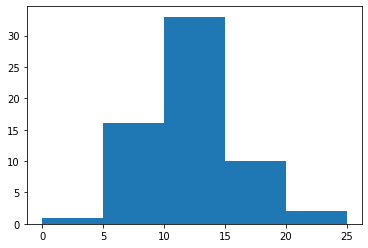

In [0]:
len_w = df.motto.apply(lambda x: len(tok.word_tokenize(x)))
len_w.hist(bins=5, range=[0,25], grid=False);  # ทำไมรูปไม่เหมือน สงสัยตัดคำไม่เหมือน

In [0]:
len_w.describe()

count    62.000000
mean     11.854839
std       3.496353
min       3.000000
25%       9.000000
50%      12.000000
75%      14.000000
max      21.000000
Name: motto, dtype: float64

## สิ่งแวดล้อม,​ เทคโนโลยี, ...

In [0]:
def contain(word):
  return df[df.motto.str.contains(word)]

In [0]:
contain('สิ่งแวดล้อม')

,year,motto,pm
34,2536,ยึดมั่นประชาธิปไตย ร่วมใจพัฒนา รักษาสิ่งแวดล้อม,นายชวน หลีกภัย
35,2537,ยึดมั่นประชาธิปไตย ร่วมใจพัฒนา รักษาสิ่งแวดล้อม,นายชวน หลีกภัย
36,2538,สืบสานวัฒนธรรมไทย ร่วมใจพัฒนา รักษาสิ่งแวดล้อม,นายชวน หลีกภัย


In [0]:
contain('เทคโนโลยี')

,year,motto,pm
44,2546,เรียนรู้ตลอดชีวิต คิดอย่างสร้างสรรค์ ก้าวทันเท...,พ.ต.ท.ทักษิณ ชินวัตร
53,2555,สามัคคี มีความรู้คู่ปัญญา คงรักษาความเป็นไทย ใ...,น.ส.ยิ่งลักษณ์ ชินวัตร
59,2561,รู้คิด รู้เท่าทัน สร้างสรรค์เทคโนโลยี,พล.อ.ประยุทธ์ จันทร์โอชา


In [0]:
contain('ประชาธิปไตย')

,year,motto,pm
34,2536,ยึดมั่นประชาธิปไตย ร่วมใจพัฒนา รักษาสิ่งแวดล้อม,นายชวน หลีกภัย
35,2537,ยึดมั่นประชาธิปไตย ร่วมใจพัฒนา รักษาสิ่งแวดล้อม,นายชวน หลีกภัย
41,2543,มีวินัย ใฝ่เรียนรู้ คู่คุณธรรม นำประชาธิปไตย,นายชวน หลีกภัย
42,2544,มีวินัย ใฝ่เรียนรู้ คู่คุณธรรม นำประชาธิปไตย,นายชวน หลีกภัย


In [0]:
contain('ปฏิวัติ')

,year,motto,pm
1,2502,ขอให้เด็กสมัยปฏิวัติของข้าพเจ้า จงเป็นเด็กที่ร...,จอมพล สฤษดิ์ ธนะรัชต์
2,2503,ขอให้เด็กสมัยปฏิวัติของข้าพเจ้า จงเป็นเด็กที่ร...,จอมพล สฤษดิ์ ธนะรัชต์
3,2504,ขอให้เด็กสมัยปฏิวัติของข้าพเจ้า จงเป็นเด็กที่อ...,จอมพล สฤษดิ์ ธนะรัชต์
4,2505,ขอให้เด็กสมัยปฏิวัติของข้าพเจ้า จงเป็นเด็กที่ป...,จอมพล สฤษดิ์ ธนะรัชต์
5,2506,ขอให้เด็กสมัยปฏิวัติของข้าพเจ้า จงเป็นเด็กที่ม...,จอมพล สฤษดิ์ ธนะรัชต์


# น่าทำต่อ

- แปลงเป็น vector แล้ว plot ให้ cluster เป็นกลุ่ม